# Capstone Project: Random Forest Regression: SGCarMart Used Cars Price Predictor

In [1]:
import pandas as pd
import numpy as np
from datetime import date

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import matplotlib.pyplot as plt
import seaborn as sns

### Pre-defined Functions

In [2]:
def plot_corr_matrix_heatmap(df):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df.corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure to control size of heatmap
    fig, ax = plt.subplots(figsize=(15, 15))

    # Create a custom color palette
    cmap = sns.diverging_palette(220, 20, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
    # Blue = Good (low correlation), Red = Bad (high correlation) between the independent variables

    # Plot the heatmap
    sns.heatmap(df.corr(), mask=mask, annot=True, square=True, cmap=cmap, vmin=-1, vmax=1, ax=ax)

    # Prevent Heatmap Cut-Off Issue
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    plt.show()

In [3]:
def linear_regression_analysis(X, Y):
    """
    Perform linear regression analysis and return the summary of the results.

    Parameters:
    X (DataFrame): Independent variables (features)
    Y (Series): Dependent variable (target)

    Returns:
    summary: Summary of the regression results
    """
    # Add a constant to the independent variables
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(Y, X)
    results = model.fit()

    # Return the summary of the results
    return results.summary()

In [4]:
def random_forest_analysis(X, Y, n_estimators=100, random_state=42):
    """
    Perform Random Forest regression analysis and return the model's performance metrics.

    Parameters:
    X (DataFrame): Independent variables (features)
    Y (Series): Dependent variable (target)
    n_estimators (int): Number of trees in the forest (default is 100)
    random_state (int): Random seed for reproducibility (default is 42)

    Returns:
    dict: Dictionary containing RMSE and R^2 score
    """
    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    # Fit the model
    rf.fit(X, Y)

    # Predict the target variable
    Y_pred = rf.predict(X)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))
    r2 = r2_score(Y, Y_pred)

    return {'RMSE': rmse, 'R^2': r2}

### Section 1: DataFrame Loading, Cleaning

In [5]:
# Use the dir() function to view all variables in the current environment.
# Refer to this link for more information: https://stackoverflow.com/questions/633127/viewing-all-defined-variables
# This link provides a solution to view all defined variables in the current environment.

In [6]:
df_main = pd.read_csv('sgcarmart_used_cars_prices_03092024.csv',index_col=0)

df_main.columns
len(df_main.columns)

19

In [7]:
df_main.sample(10)

,LISTING_URL,BRAND,PRICE,DEPRE_YEARLY,REG_DATE,MILEAGE_KM,MANUFACTURED_YEAR,ROAD_TAX_YEARLY,TRANSMISSION,DEREG_VALUE_FROM_SCRAPE_DATE,SCRAPE_DATE,OMV,ARF,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,ENGINE_CAPACITY_CC,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE
703,https://www.sgcarmart.com/used_cars/info.php?I...,Maserati GranTurismo 4.2A,100000.0,15800.0,19-Aug-11,148089.0,2011,5632.0,Auto,25767.0,3/9/2024,91535.0,91535.0,40714.0,2288.0,4244.0,1880.0,NaN,Sports Car
2956,https://www.sgcarmart.com/used_cars/info.php?I...,Mazda 3 1.5A Sunroof,25800.0,12360.0,29-Apr-16,NaN,2016,682.0,Auto,13764.0,3/9/2024,15841.0,10841.0,47300.0,580.0,1496.0,1321.0,3.0,Mid-Sized Sedan
676,https://www.sgcarmart.com/used_cars/info.php?I...,Toyota Voxy Hybrid 1.8A SZ,224800.0,21280.0,26-Jul-24,8.0,MPV,974.0,2024,101293.0,3/9/2024,NaN,NaN,100000.0,3287.0,1797.0,1700.0,1.0,NaN
5142,https://www.sgcarmart.com/used_cars/info.php?I...,Toyota Harrier 2.0A Premium Panoramic Roof,54800.0,17320.0,20-Oct-16,NaN,2015,1196.0,Auto,33559.0,3/9/2024,34960.0,35944.0,56410.0,766.0,1986.0,1610.0,1.0,SUV
906,https://www.sgcarmart.com/used_cars/info.php?I...,Kia Cerato 1.6A SX,75800.0,14840.0,8-Mar-19,64950.0,2018,738.0,Auto,24043.0,3/9/2024,17798.0,17798.0,25689.0,1644.0,1591.0,1287.0,1.0,Mid-Sized Sedan
260,https://www.sgcarmart.com/used_cars/info.php?I...,BMW 4 Series 428i Coupe Sunroof,39500.0,NaN,27-Jan-15,157000.0,2014,1210.0,Auto,29814.0,3/9/2024,47514.0,53520.0,76889.0,123.0,1997.0,1470.0,4.0,Sports Car
5179,https://www.sgcarmart.com/used_cars/info.php?I...,Nissan Qashqai 1.2A DIG-T,25888.0,11370.0,4-May-16,NaN,2016,508.0,Auto,15552.0,3/9/2024,18974.0,13974.0,47300.0,605.0,1197.0,1285.0,2.0,SUV
2916,https://www.sgcarmart.com/used_cars/info.php?I...,Mercedes-Benz GLC-Class GLC300 Coupe Mild Hybr...,221800.0,27990.0,12-Jan-21,40200.0,SUV,1202.0,2020,91373.0,3/9/2024,NaN,NaN,40301.0,2318.0,1991.0,1825.0,2.0,NaN
793,https://www.sgcarmart.com/used_cars/info.php?I...,Suzuki APV 1.6A,51500.0,9980.0,2-Dec-09,156000.0,2009,1107.0,Auto,15781.0,3/9/2024,14361.0,14361.0,30574.0,1863.0,1590.0,1330.0,6.0,MPV
5060,https://www.sgcarmart.com/used_cars/info.php?I...,BMW 1 Series 116i Sportline,119800.0,15200.0,21-May-21,95000.0,2021,684.0,Auto,54668.0,3/9/2024,31057.0,35480.0,41801.0,2437.0,1499.0,1340.0,1.0,Hatchback


In [8]:
df_clean = df_main.drop(['LISTING_URL', 'SCRAPE_DATE'],axis=1) #Drop columns that were used for reference purposes.
# There are NA entries in the dataset.
# Dropping these NA values is necessary to avoid future problems.
# Null values may occur due to missing data or formatting issues in the car listings.
# Varying ways of organizing information in a single listing can contribute to these formatting issues.

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6719 entries, 0 to 6718
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BRAND                         6719 non-null   object 
 1   PRICE                         6670 non-null   float64
 2   DEPRE_YEARLY                  6561 non-null   float64
 3   REG_DATE                      6719 non-null   object 
 4   MILEAGE_KM                    5760 non-null   float64
 5   MANUFACTURED_YEAR             6719 non-null   object 
 6   ROAD_TAX_YEARLY               6640 non-null   float64
 7   TRANSMISSION                  6719 non-null   object 
 8   DEREG_VALUE_FROM_SCRAPE_DATE  6254 non-null   float64
 9   OMV                           5637 non-null   float64
 10  ARF                           5648 non-null   float64
 11  COE_FROM_SCRAPE_DATE          6339 non-null   float64
 12  DAYS_OF_COE_LEFT              6696 non-null   float64
 13  ENGINE_C

In [9]:
# After dropping null values, we have rows of data remaining
df_clean.dropna(inplace=True)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4316 entries, 1 to 6718
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BRAND                         4316 non-null   object 
 1   PRICE                         4316 non-null   float64
 2   DEPRE_YEARLY                  4316 non-null   float64
 3   REG_DATE                      4316 non-null   object 
 4   MILEAGE_KM                    4316 non-null   float64
 5   MANUFACTURED_YEAR             4316 non-null   object 
 6   ROAD_TAX_YEARLY               4316 non-null   float64
 7   TRANSMISSION                  4316 non-null   object 
 8   DEREG_VALUE_FROM_SCRAPE_DATE  4316 non-null   float64
 9   OMV                           4316 non-null   float64
 10  ARF                           4316 non-null   float64
 11  COE_FROM_SCRAPE_DATE          4316 non-null   float64
 12  DAYS_OF_COE_LEFT              4316 non-null   float64
 13  ENGINE_C

In [10]:
df_clean.sample(10)

,BRAND,PRICE,DEPRE_YEARLY,REG_DATE,MILEAGE_KM,MANUFACTURED_YEAR,ROAD_TAX_YEARLY,TRANSMISSION,DEREG_VALUE_FROM_SCRAPE_DATE,OMV,ARF,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,ENGINE_CAPACITY_CC,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE
329,BMW 5 Series 523i,75800.0,12640.0,7-Sep-10,219000.0,2010,2514.0,Auto,19730.0,36407.0,36407.0,32914.0,1863.0,2497.0,1650.0,5.0,Luxury Sedan
5684,Mazda 3 HB 1.5A Deluxe Sunroof,57800.0,12810.0,27-Jun-18,124000.0,2018,682.0,Auto,24661.0,17927.0,17927.0,34110.0,1368.0,1496.0,1329.0,2.0,Hatchback
3781,Toyota Corolla Altis 1.6A Eco,56800.0,15910.0,10-Oct-17,82909.0,2017,742.0,Auto,20899.0,19990.0,14990.0,36001.0,1131.0,1598.0,1230.0,1.0,Mid-Sized Sedan
2227,Mazda CX-3 2.0A Standard,60400.0,13020.0,31-Aug-18,79000.0,2018,1210.0,Auto,23942.0,16843.0,16843.0,32551.0,1132.0,1998.0,1290.0,1.0,SUV
6272,Toyota Alphard 3.0A Moonroof,33000.0,11970.0,7-Jun-07,170000.0,2007,3570.0,Auto,14908.0,42496.0,46746.0,54088.0,1003.0,2994.0,1910.0,4.0,MPV
5806,Subaru Exiga 2.0A GT Moonroof,85800.0,15850.0,12-Jun-10,166000.0,2008,1809.0,Auto,21364.0,35867.0,35867.0,39463.0,1953.0,1994.0,1590.0,4.0,MPV
6161,Toyota Raize 1.0A XS,87000.0,13650.0,16-Sep-20,25000.0,2020,392.0,Auto,22830.0,19234.0,9234.0,26351.0,2192.0,996.0,1040.0,1.0,SUV
3478,Subaru Impreza 4D 1.6i-S Sunroof,46800.0,13180.0,18-Sep-17,82240.0,2017,744.0,Auto,19704.0,13486.0,13486.0,36001.0,1099.0,1600.0,1449.0,1.0,Mid-Sized Sedan
400,Kia Cerato K3 1.6A,42800.0,12990.0,22-Jun-17,61400.0,2017,738.0,Auto,20405.0,12935.0,12935.0,45201.0,1008.0,1591.0,1295.0,1.0,Mid-Sized Sedan
4221,Mitsubishi i Casual,50500.0,9480.0,4-Jan-10,98800.0,2009,489.0,Auto,17039.0,14946.0,14946.0,31976.0,1923.0,659.0,900.0,1.0,Hatchback


In [11]:
# 18 variables in columns after cleaning
print(df_clean.columns,'\n',len(df_clean.columns))

Index(['BRAND', 'PRICE', 'DEPRE_YEARLY', 'REG_DATE', 'MILEAGE_KM',
       'MANUFACTURED_YEAR', 'ROAD_TAX_YEARLY', 'TRANSMISSION',
       'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'VEHICLE_TYPE'],
      dtype='object') 
 17


## Section 2: Data Categorizing

### Section 2.1: One-hot encoding TRANSMISSION Column

In [12]:
#The transmission options in this dataset are limited to Auto or Manual.
#To handle this, apply one-hot encoding to represent the transmission variable.
df_clean['TRANSMISSION'].value_counts()

TRANSMISSION
Auto      4276
Manual      40
Name: count, dtype: int64

In [13]:
# Transmission conversion -> 1 for auto, 0 for manual (just 1 column only)
df_clean['TRANSMISSION_CONVERT'] = df_clean['TRANSMISSION'].apply(lambda x: 1 if x == 'Auto' else 0)
df_clean.drop('TRANSMISSION',axis=1,inplace=True)
df_clean.rename(columns={'TRANSMISSION_CONVERT':"TRANSMISSION"}, inplace=True)  # Renaming column back

In [14]:
df_clean.sample(10)

,BRAND,PRICE,DEPRE_YEARLY,REG_DATE,MILEAGE_KM,MANUFACTURED_YEAR,ROAD_TAX_YEARLY,DEREG_VALUE_FROM_SCRAPE_DATE,OMV,ARF,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,ENGINE_CAPACITY_CC,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE,TRANSMISSION
796,BMW 2 Series 216i Gran Tourer,133800.0,16840.0,24-Jun-21,61497.0,2021,684.0,61364.0,33161.0,38426.0,47821.0,2460.0,1499.0,1490.0,1.0,MPV,1
3114,Subaru Forester 2.5T,67000.0,18160.0,13-May-08,159701.0,2008,2625.0,14286.0,20670.0,22737.0,38712.0,1344.0,2457.0,1510.0,3.0,SUV,1
3962,Audi A7 Sportback 2.0A TFSI,90000.0,37350.0,25-Feb-16,165000.0,2015,1194.0,45258.0,54264.0,69676.0,46970.0,516.0,1984.0,1730.0,3.0,Luxury Sedan,1
6150,Volkswagen Golf 1.0A TSI Trendline,53800.0,11960.0,25-May-18,91000.0,2017,392.0,26185.0,18517.0,18517.0,38000.0,1336.0,999.0,1257.0,3.0,Hatchback,1
4187,MINI John Cooper Works GP 2.0A,182588.0,22620.0,8-Jun-21,27000.0,2020,1210.0,76225.0,48059.0,59283.0,47806.0,2464.0,1998.0,1330.0,1.0,Sports Car,1
2254,Hyundai Sonata VIII 2.0A GLS Sunroof,26500.0,12900.0,3-Oct-15,149000.0,2015,1212.0,20304.0,23672.0,25141.0,60001.0,374.0,1999.0,1460.0,2.0,Luxury Sedan,1
562,Honda Civic Type-R 2.0M VTEC Turbo,292800.0,27180.0,8-Aug-24,10.0,2024,1208.0,119135.0,38337.0,45672.0,106101.0,3319.0,1995.0,1430.0,1.0,Sports Car,0
3958,Nissan Note 1.2A,53800.0,11440.0,27-Feb-19,85000.0,2019,508.0,15296.0,13467.0,5000.0,26301.0,1613.0,1198.0,1048.0,2.0,Hatchback,1
5502,Volkswagen Golf 1.0A TSI Trendline,63800.0,14150.0,31-Jul-18,47781.0,2018,392.0,23830.0,17008.0,17008.0,32699.0,1102.0,999.0,1257.0,1.0,Hatchback,1
3711,Toyota Harrier 2.0A Elegance,29800.0,30230.0,7-May-15,98000.0,2014,1196.0,14718.0,26441.0,19018.0,77600.0,243.0,1986.0,1580.0,2.0,SUV,1


In [15]:
# Performing whitespace stripping prior to dtype manipulation
df_clean['VEHICLE_TYPE'].apply(str.strip)
df_clean['VEHICLE_TYPE'].apply(str.lstrip)

# Inspection of the type of Vehicles
df_clean['VEHICLE_TYPE'].value_counts()

VEHICLE_TYPE
SUV                1191
Luxury Sedan        875
Mid-Sized Sedan     674
Sports Car          547
Hatchback           503
MPV                 436
Stationwagon         89
Others                1
Name: count, dtype: int64

In [16]:
# Performing whitespace stripping prior to dtype manipulation
#df_clean['FUEL_TYPE'].apply(str.strip)
#df_clean['FUEL_TYPE'].apply(str.lstrip)

# Inspection of the type of Vehicles
#df_clean['FUEL_TYPE'].value_counts()

### Section 2.2: Datetime conversion

In [17]:
#df_clean['REG_DATE'] = pd.to_datetime(df_clean['REG_DATE'], format='%d-%b-%y')
#df_clean['MANUFACTURED_YEAR'] = df_clean['MANUFACTURED_YEAR'].astype(int)
#df_clean[['REG_DATE','MANUFACTURED_YEAR']].dtypes

#print(df_clean[['REG_DATE', 'MANUFACTURED_YEAR']].dtypes)

#df_clean['REG_DATE'] = pd.to_datetime(df_clean['REG_DATE'], format='%d-%b-%Y')
#df_clean['MANUFACTURED_YEAR'] = df_clean['MANUFACTURED_YEAR'].astype(int)

# Display the data types
#print(df_clean[['REG_DATE', 'MANUFACTURED_YEAR']].dtypes)

# Check for any entries that couldn't be converted
#invalid_dates = df_clean[df_clean['REG_DATE'].isna()]
#print("Invalid dates found:\n", invalid_dates)

In [18]:
# Converting reg_date to datetime follwed by int in YYYYMMDD, and Manufactured year to int

# Converting REG_DATE to datetime and MANUFACTURED_YEAR to int
df_clean['REG_DATE'] = pd.to_datetime(df_clean['REG_DATE'], format='%d-%b-%y', errors='coerce')
df_clean['MANUFACTURED_YEAR'] = df_clean['MANUFACTURED_YEAR'].astype(int)

# Extracting year, month, and day
df_clean['YEAR'] = df_clean['REG_DATE'].dt.year
df_clean['MONTH'] = df_clean['REG_DATE'].dt.month
df_clean['DAY'] = df_clean['REG_DATE'].dt.day

# Creating YYYYMMDD format
df_clean['REG_DATE_CONVERT'] = df_clean['YEAR']*10000 + df_clean['MONTH']*100 + df_clean['DAY']

# Dropping the original REG_DATE column and renaming the new column
df_clean.drop('REG_DATE', axis=1, inplace=True)
df_clean.rename(columns={'REG_DATE_CONVERT': 'REG_DATE'}, inplace=True)

# Dropping temporary columns
df_clean = df_clean.drop(columns=['YEAR', 'MONTH', 'DAY'])

# Displaying the data types
print(df_clean[['REG_DATE', 'MANUFACTURED_YEAR']].dtypes)
print(df_clean)


REG_DATE             int32
MANUFACTURED_YEAR    int32
dtype: object
                                          BRAND     PRICE  DEPRE_YEARLY  \
1                            Honda HR-V 1.5A LX   78800.0       14790.0   
3                    Mercedes-Benz A-Class A200   53800.0       18370.0   
4             Toyota Previa 2.4A Aeras Moonroof  157800.0       22740.0   
5                Subaru Forester 2.0i-L Sunroof   45800.0       13700.0   
6                          Audi A4 1.8A TFSI MU   17300.0       17440.0   
...                                         ...       ...           ...   
6709        Mercedes-Benz C-Class C200 AMG Line   91988.0       20870.0   
6712                         Honda Jazz 1.5A RS   27000.0       13930.0   
6714  Toyota Alphard 3.5A SA C-Package Moonroof  116800.0       33570.0   
6716                Volkswagen Passat 1.8A TFSI   46800.0       14760.0   
6718                Rolls-Royce Ghost Series II  668800.0      323420.0   

      MILEAGE_KM  MANUFACTURED_

In [19]:
df_clean.dtypes

BRAND                            object
PRICE                           float64
DEPRE_YEARLY                    float64
MILEAGE_KM                      float64
MANUFACTURED_YEAR                 int32
ROAD_TAX_YEARLY                 float64
DEREG_VALUE_FROM_SCRAPE_DATE    float64
OMV                             float64
ARF                             float64
COE_FROM_SCRAPE_DATE            float64
DAYS_OF_COE_LEFT                float64
ENGINE_CAPACITY_CC              float64
CURB_WEIGHT_KG                  float64
NO_OF_OWNERS                    float64
VEHICLE_TYPE                     object
TRANSMISSION                      int64
REG_DATE                          int32
dtype: object

In [20]:
if df_main['SCRAPE_DATE'].dtype == object:
    df_main['SCRAPE_DATE'] = \
    pd.to_datetime(df_main['SCRAPE_DATE']).dt.year # Convert the scrape date column to an integer format to enable operations on the dates.
    df_main['SCRAPE_DATE'] # Checking dtype

In [21]:
# Convert the current scrape date from the main dataframe to a datetime object.

# Calculate the number of years from the year of manufacture to the current year to determine how new the car is.
df_clean['CAR_AGE'] = df_main['SCRAPE_DATE'] - df_clean['MANUFACTURED_YEAR'] # Obtain the values for the age of the car.
df_clean['CAR_AGE'].astype(int)

1        5
3        8
4        5
5        7
6       14
        ..
6709     7
6712     8
6714     9
6716     9
6718     9
Name: CAR_AGE, Length: 4316, dtype: int32

In [22]:
# Rearrange Columns 
df_clean = df_clean[['BRAND', 'PRICE', 'DEPRE_YEARLY', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 
                    'REG_DATE', 'MANUFACTURED_YEAR', 'CAR_AGE', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 
                    'ENGINE_CAPACITY_CC', 'ROAD_TAX_YEARLY', 'CURB_WEIGHT_KG',
                    'NO_OF_OWNERS', 'VEHICLE_TYPE', 'TRANSMISSION']]
df_clean.head()

,BRAND,PRICE,DEPRE_YEARLY,MILEAGE_KM,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,REG_DATE,MANUFACTURED_YEAR,CAR_AGE,DEREG_VALUE_FROM_SCRAPE_DATE,OMV,ARF,ENGINE_CAPACITY_CC,ROAD_TAX_YEARLY,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE,TRANSMISSION
1,Honda HR-V 1.5A LX,78800.0,14790.0,94000.0,25501.0,1647.0,20190321,2019,5.0,27800.0,22254.0,23156.0,1496.0,682.0,1200.0,1.0,SUV,1
3,Mercedes-Benz A-Class A200,53800.0,18370.0,88453.0,56500.0,820.0,20170103,2016,8.0,26349.0,24971.0,21960.0,1595.0,740.0,1395.0,1.0,Hatchback,1
4,Toyota Previa 2.4A Aeras Moonroof,157800.0,22740.0,65000.0,41510.0,2199.0,20200923,2019,5.0,55345.0,34487.0,40282.0,2362.0,1638.0,1775.0,1.0,MPV,1
5,Subaru Forester 2.0i-L Sunroof,45800.0,13700.0,106000.0,53001.0,1003.0,20170627,2017,7.0,23659.0,14601.0,14601.0,1995.0,1208.0,1591.0,2.0,SUV,1
6,Audi A4 1.8A TFSI MU,17300.0,17440.0,160000.0,16457.0,38.0,20100930,2010,14.0,3264.0,36125.0,36125.0,1798.0,1366.0,1450.0,2.0,Luxury Sedan,1


## Section 2.3: VEHICLE_TYPE To Dummy Variables

In [23]:
# Making Dummy Variables out of Vehicle Types:

x_vehtype_dummy = patsy.dmatrix('VEHICLE_TYPE',data=df_clean,return_type='dataframe')
x_vehtype_dummy.head()


,Intercept,VEHICLE_TYPE[T.Luxury Sedan],VEHICLE_TYPE[T.MPV],VEHICLE_TYPE[T.Mid-Sized Sedan],VEHICLE_TYPE[T.Others],VEHICLE_TYPE[T.SUV],VEHICLE_TYPE[T.Sports Car],VEHICLE_TYPE[T.Stationwagon]
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df_clean2 = df_clean.join(x_vehtype_dummy)
df_clean2

,BRAND,PRICE,DEPRE_YEARLY,MILEAGE_KM,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,REG_DATE,MANUFACTURED_YEAR,CAR_AGE,DEREG_VALUE_FROM_SCRAPE_DATE,...,VEHICLE_TYPE,TRANSMISSION,Intercept,VEHICLE_TYPE[T.Luxury Sedan],VEHICLE_TYPE[T.MPV],VEHICLE_TYPE[T.Mid-Sized Sedan],VEHICLE_TYPE[T.Others],VEHICLE_TYPE[T.SUV],VEHICLE_TYPE[T.Sports Car],VEHICLE_TYPE[T.Stationwagon]
1,Honda HR-V 1.5A LX,78800.0,14790.0,94000.0,25501.0,1647.0,20190321,2019,5.0,27800.0,...,SUV,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Mercedes-Benz A-Class A200,53800.0,18370.0,88453.0,56500.0,820.0,20170103,2016,8.0,26349.0,...,Hatchback,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Toyota Previa 2.4A Aeras Moonroof,157800.0,22740.0,65000.0,41510.0,2199.0,20200923,2019,5.0,55345.0,...,MPV,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,Subaru Forester 2.0i-L Sunroof,45800.0,13700.0,106000.0,53001.0,1003.0,20170627,2017,7.0,23659.0,...,SUV,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,Audi A4 1.8A TFSI MU,17300.0,17440.0,160000.0,16457.0,38.0,20100930,2010,14.0,3264.0,...,Luxury Sedan,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6709,Mercedes-Benz C-Class C200 AMG Line,91988.0,20870.0,121000.0,49996.0,1133.0,20171101,2017,7.0,49676.0,...,Luxury Sedan,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6712,Honda Jazz 1.5A RS,27000.0,13930.0,116350.0,51301.0,549.0,20160318,2016,8.0,14063.0,...,Hatchback,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6714,Toyota Alphard 3.5A SA C-Package Moonroof,116800.0,33570.0,83257.0,53001.0,910.0,20170324,2015,9.0,50914.0,...,MPV,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6716,Volkswagen Passat 1.8A TFSI,46800.0,14760.0,75000.0,55501.0,791.0,20161115,2015,9.0,29438.0,...,Luxury Sedan,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Section 2.4: Car Brand Categorization. Includes:
* Splitting them into Dummy Variables
* Indexing them into price range categories (perhaps better metric over vehicle types)
* Converting lesser-known brands into "others"

In [25]:
# Renaming Brand Names to their actual names

df_clean2.loc[df_clean2['BRAND'] == 'Aston','BRAND'] = 'Aston Martin'
df_clean2.loc[df_clean2['BRAND'] == 'Land','BRAND'] = 'Land Rover'
df_clean2.loc[df_clean2['BRAND'] == 'Alfa', 'BRAND'] = 'Alfa Romeo'

In [26]:
# Cleaning whitespaces from the values in "Brand" to prevent any messup later
df_clean2['BRAND'].apply(str.strip)

# Checking the number of brands in the dataset
print("# Of rows in DataFrame in Brands Column:\n", df_clean2.loc[:,'BRAND'])
print("\nValue Counts of Brands:\n", df_clean2.loc[:,'BRAND'].value_counts())
print("\n# of Brands:", len(df_clean2.loc[:,'BRAND'].value_counts()))

# New Column ATAS
# New Column Budget Cars
# Top 20 brands
# Am I comfortable with grouping uncommon cars into others?

# Of rows in DataFrame in Brands Column:
 1                              Honda HR-V 1.5A LX
3                      Mercedes-Benz A-Class A200
4               Toyota Previa 2.4A Aeras Moonroof
5                  Subaru Forester 2.0i-L Sunroof
6                            Audi A4 1.8A TFSI MU
                          ...                    
6709          Mercedes-Benz C-Class C200 AMG Line
6712                           Honda Jazz 1.5A RS
6714    Toyota Alphard 3.5A SA C-Package Moonroof
6716                  Volkswagen Passat 1.8A TFSI
6718                  Rolls-Royce Ghost Series II
Name: BRAND, Length: 4316, dtype: object

Value Counts of Brands:
 BRAND
Honda Civic 1.6A VTi                                  56
Honda Vezel 1.5A X                                    52
Nissan Qashqai 1.2A DIG-T                             44
Toyota Corolla Altis 1.6A Elegance                    37
Toyota Vios 1.5A E                                    35
                                                  

## Section 3: Data Visualization
* EDA  
* Correlation Matrix  
* Pairplots  

### Section 3.1: Preliminary Correlation Exploration
### Section 3.1.1: Analysis without Car Brands and Vehicle Types for Feature Dropping

In [27]:
df_clean2.columns

Index(['BRAND', 'PRICE', 'DEPRE_YEARLY', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'REG_DATE', 'MANUFACTURED_YEAR', 'CAR_AGE',
       'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 'ENGINE_CAPACITY_CC',
       'ROAD_TAX_YEARLY', 'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'VEHICLE_TYPE',
       'TRANSMISSION', 'Intercept', 'VEHICLE_TYPE[T.Luxury Sedan]',
       'VEHICLE_TYPE[T.MPV]', 'VEHICLE_TYPE[T.Mid-Sized Sedan]',
       'VEHICLE_TYPE[T.Others]', 'VEHICLE_TYPE[T.SUV]',
       'VEHICLE_TYPE[T.Sports Car]', 'VEHICLE_TYPE[T.Stationwagon]'],
      dtype='object')

In [28]:
df_price_no_brands = df_clean2[['PRICE', 'DEPRE_YEARLY', 'MILEAGE_KM',
       'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 'REG_DATE',
       'MANUFACTURED_YEAR', 'CAR_AGE', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV',
       'ARF', 'ENGINE_CAPACITY_CC', 'ROAD_TAX_YEARLY', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'VEHICLE_TYPE', 'TRANSMISSION']]
df_price_no_brands.sample(10)

,PRICE,DEPRE_YEARLY,MILEAGE_KM,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,REG_DATE,MANUFACTURED_YEAR,CAR_AGE,DEREG_VALUE_FROM_SCRAPE_DATE,OMV,ARF,ENGINE_CAPACITY_CC,ROAD_TAX_YEARLY,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE,TRANSMISSION
824,26800.0,13600.0,108793.0,60001.0,493.0,20160112,2015,9.0,17323.0,16702.0,16702.0,1362.0,604.0,1650.0,3.0,MPV,1
5730,53800.0,13650.0,77000.0,47002.0,1189.0,20171228,2017,7.0,26680.0,17074.0,17074.0,1998.0,1210.0,1532.0,2.0,MPV,1
3252,30800.0,17350.0,89000.0,45002.0,520.0,20160301,2015,9.0,12180.0,19973.0,9973.0,1496.0,682.0,1190.0,2.0,SUV,1
5035,106800.0,17740.0,32000.0,31759.0,1890.0,20191119,2019,5.0,38048.0,26189.0,28665.0,1595.0,740.0,1435.0,1.0,SUV,1
3996,39800.0,9430.0,170000.0,29670.0,1528.0,20081122,2008,16.0,12518.0,17900.0,17900.0,1498.0,1026.0,1175.0,3.0,Mid-Sized Sedan,1
5512,129188.0,13270.0,156000.0,99116.0,3530.0,20140529,2014,10.0,79293.0,42793.0,46911.0,1991.0,1322.0,1655.0,4.0,Luxury Sedan,1
103,128800.0,23470.0,123000.0,31001.0,1589.0,20190123,2018,6.0,49724.0,42569.0,51597.0,1991.0,1202.0,1705.0,2.0,SUV,1
3680,93900.0,18890.0,60000.0,34381.0,1127.0,20180816,2018,6.0,38616.0,33223.0,38513.0,1984.0,1194.0,1480.0,1.0,Luxury Sedan,1
5250,329888.0,39480.0,60000.0,49500.0,2319.0,20210202,2019,5.0,146596.0,100618.0,153113.0,2998.0,2384.0,2320.0,1.0,SUV,1
4556,112800.0,15510.0,70000.0,49640.0,2402.0,20210426,2021,3.0,47585.0,19473.0,19473.0,1598.0,742.0,1315.0,2.0,Mid-Sized Sedan,1


In [29]:
# Corr Matrix
df_price_no_brands.loc[:, 'VEHICLE_TYPE'] = df_price_no_brands['VEHICLE_TYPE'].map({'SUV': 1, 'Hatchback': 2, 'Mid-Sized Sedan': 3, 'Luxury Sedan': 4, 'Sports Car': 5, 'MPV': 6, 'Stationwagon': 7})
df_price_no_brands.corr()

,PRICE,DEPRE_YEARLY,MILEAGE_KM,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,REG_DATE,MANUFACTURED_YEAR,CAR_AGE,DEREG_VALUE_FROM_SCRAPE_DATE,OMV,ARF,ENGINE_CAPACITY_CC,ROAD_TAX_YEARLY,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE,TRANSMISSION
PRICE,1.000000,0.598982,-0.446287,0.344683,0.478349,0.272236,0.214191,-0.214191,0.644261,0.630746,0.680676,0.560515,0.496517,0.408985,-0.013533,0.107761,-0.068941
DEPRE_YEARLY,0.598982,1.000000,-0.325652,0.222362,0.142464,0.159545,0.128829,-0.128829,0.781301,0.834473,0.816711,0.657182,0.575745,0.447257,0.024489,0.127412,-0.054689
MILEAGE_KM,-0.446287,-0.325652,1.000000,-0.285616,-0.429866,-0.695880,-0.621115,0.621115,-0.448417,-0.244183,-0.270691,-0.101592,-0.035269,-0.046346,0.401312,0.101919,-0.014038
COE_FROM_SCRAPE_DATE,0.344683,0.222362,-0.285616,1.000000,0.340185,0.206122,0.201394,-0.201394,0.401884,0.263800,0.263693,0.243591,0.208671,0.218658,-0.062004,0.056396,-0.013542
DAYS_OF_COE_LEFT,0.478349,0.142464,-0.429866,0.340185,1.000000,0.281278,0.213154,-0.213154,0.384545,0.251859,0.232749,0.203253,0.225308,0.126363,-0.010811,0.007438,-0.053638
REG_DATE,0.272236,0.159545,-0.695880,0.206122,0.281278,1.000000,0.897474,-0.897474,0.367573,-0.024906,0.045702,-0.173851,-0.305447,-0.021368,-0.581714,-0.210756,0.056751
MANUFACTURED_YEAR,0.214191,0.128829,-0.621115,0.201394,0.213154,0.897474,1.000000,-1.000000,0.334441,-0.025510,0.037270,-0.201793,-0.284349,-0.031815,-0.532983,-0.214882,0.089113
CAR_AGE,-0.214191,-0.128829,0.621115,-0.201394,-0.213154,-0.897474,-1.000000,1.000000,-0.334441,0.025510,-0.037270,0.201793,0.284349,0.031815,0.532983,0.214882,-0.089113
DEREG_VALUE_FROM_SCRAPE_DATE,0.644261,0.781301,-0.448417,0.401884,0.384545,0.367573,0.334441,-0.334441,1.000000,0.669625,0.742194,0.512524,0.400871,0.411764,-0.096185,0.081293,-0.024418
OMV,0.630746,0.834473,-0.244183,0.263800,0.251859,-0.024906,-0.025510,0.025510,0.669625,1.000000,0.891529,0.826324,0.812231,0.542532,0.171696,0.186592,-0.014329


In [30]:
# How each feature relates to price
df_price_no_brands.corr()['PRICE'].sort_values(ascending=False)

PRICE                           1.000000
ARF                             0.680676
DEREG_VALUE_FROM_SCRAPE_DATE    0.644261
OMV                             0.630746
DEPRE_YEARLY                    0.598982
ENGINE_CAPACITY_CC              0.560515
ROAD_TAX_YEARLY                 0.496517
DAYS_OF_COE_LEFT                0.478349
CURB_WEIGHT_KG                  0.408985
COE_FROM_SCRAPE_DATE            0.344683
REG_DATE                        0.272236
MANUFACTURED_YEAR               0.214191
VEHICLE_TYPE                    0.107761
NO_OF_OWNERS                   -0.013533
TRANSMISSION                   -0.068941
CAR_AGE                        -0.214191
MILEAGE_KM                     -0.446287
Name: PRICE, dtype: float64

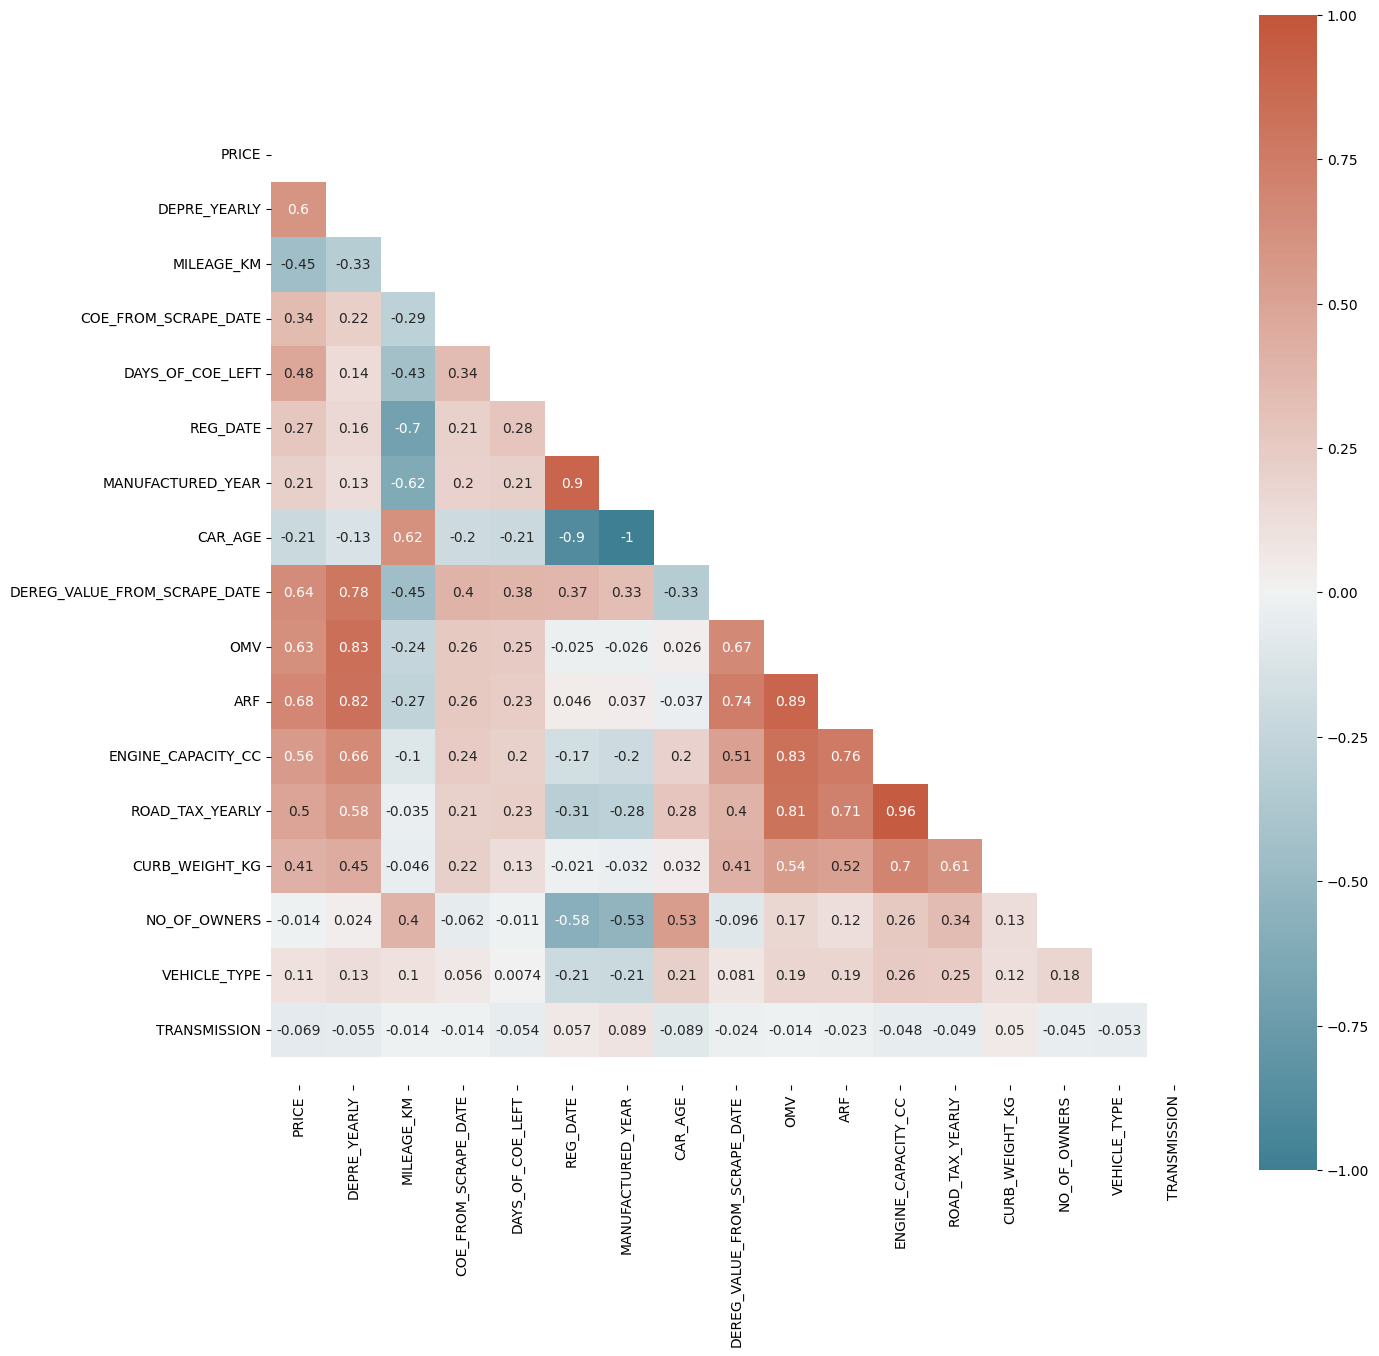

In [31]:
# Corr Matrix Heatmap Visualization

plot_corr_matrix_heatmap(df_price_no_brands)

#### From the above Corr Matrix, we can observe that a few Independent Variables are highly correlated with each other. 
Interestingly, this makes sense due to how a few of the independent variables are calculated. Therefore, some of these features can be dropped.  
1. **OMV and ARF:** 
The Additional Registration Fee (ARF) is a tax imposed upon registration of a vehicle. It is calculated based on a percentage of the Open Market Value (OMV) of the vehicle. From the correlation matrix, they have a correlation of **0.96.** Therefore, we can just keep one of this. Therefore, **ARF** will be dropped.
   
   
2. **Engine CC and Road Tax:** 
Road tax increases as engine CC increases. Therefore, having Road Tax in it would be introducing multicolinearity into the model, since both explain the same thing anyway. From the correlation matrix, they have a correlation of **0.96**. Therefore, **road tax** column will be dropped.
   
   
3. **Manufactured Year and Car Age:** 
Obviously, manufactured year can be dropped, since Car Age is derived from year of manufacture. And since car age is more intuitive, **Manufactured Year** column will be dropped.  From the correlation matrix, they have a correlation of **-1**. 
  

  
4. **Dereg Value:**  
The deregistration value of a vehicle is amount one will get back from the government upon deregistering the vehicle for use in Singapore. It is the sum of the COE rebate and the PARF rebate.
The COE rebate is a percentage of the original COE value.
The PARF rebate is a percentage of the original ARF.
Therefore, the **dereg value will be dropped**. From the corr matrix, ARF and dereg value have a correlation of **0.75.**
  
  
5. **Depreciation:** 
Annual depreciation is the amount the owner loses on the value of the vehicle per year based on the assumption that the vehicle is deregistered only at the end of its 10-yr COE life-span. The value of the car body has not been taken into account.  The formula used to derive the figure is as follows:  
Depreciation = (List Price - Minimum PARF value) ÷ remaining years of COE  
The minimum Preferential Additional Registration Fee (PARF) value is a sum of money that the vehicle owner gets for deregistering his vehicle at the end of its 10-yr COE. It is a function of the Open Market Value (OMV) or Additional Registration Fee (ARF). Commercial vehicles and cars with renewed COE have no minimum PARF value.  Depreciation and ARF have a correlation of **0.88**. **Depreciation** will be dropped.


### Section 3.1.2: Removing Independent Variables with High Correlation to each other

In [32]:
df_price_no_brands = df_price_no_brands.drop(['DEPRE_YEARLY', 'REG_DATE', 'MANUFACTURED_YEAR', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'ARF', 'ROAD_TAX_YEARLY', 'VEHICLE_TYPE'], axis=1)
df_price_no_brands.columns

Index(['PRICE', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

### Section 3.1.3: Re-Visualizing New Correlation Matrix (with a few features dropped)

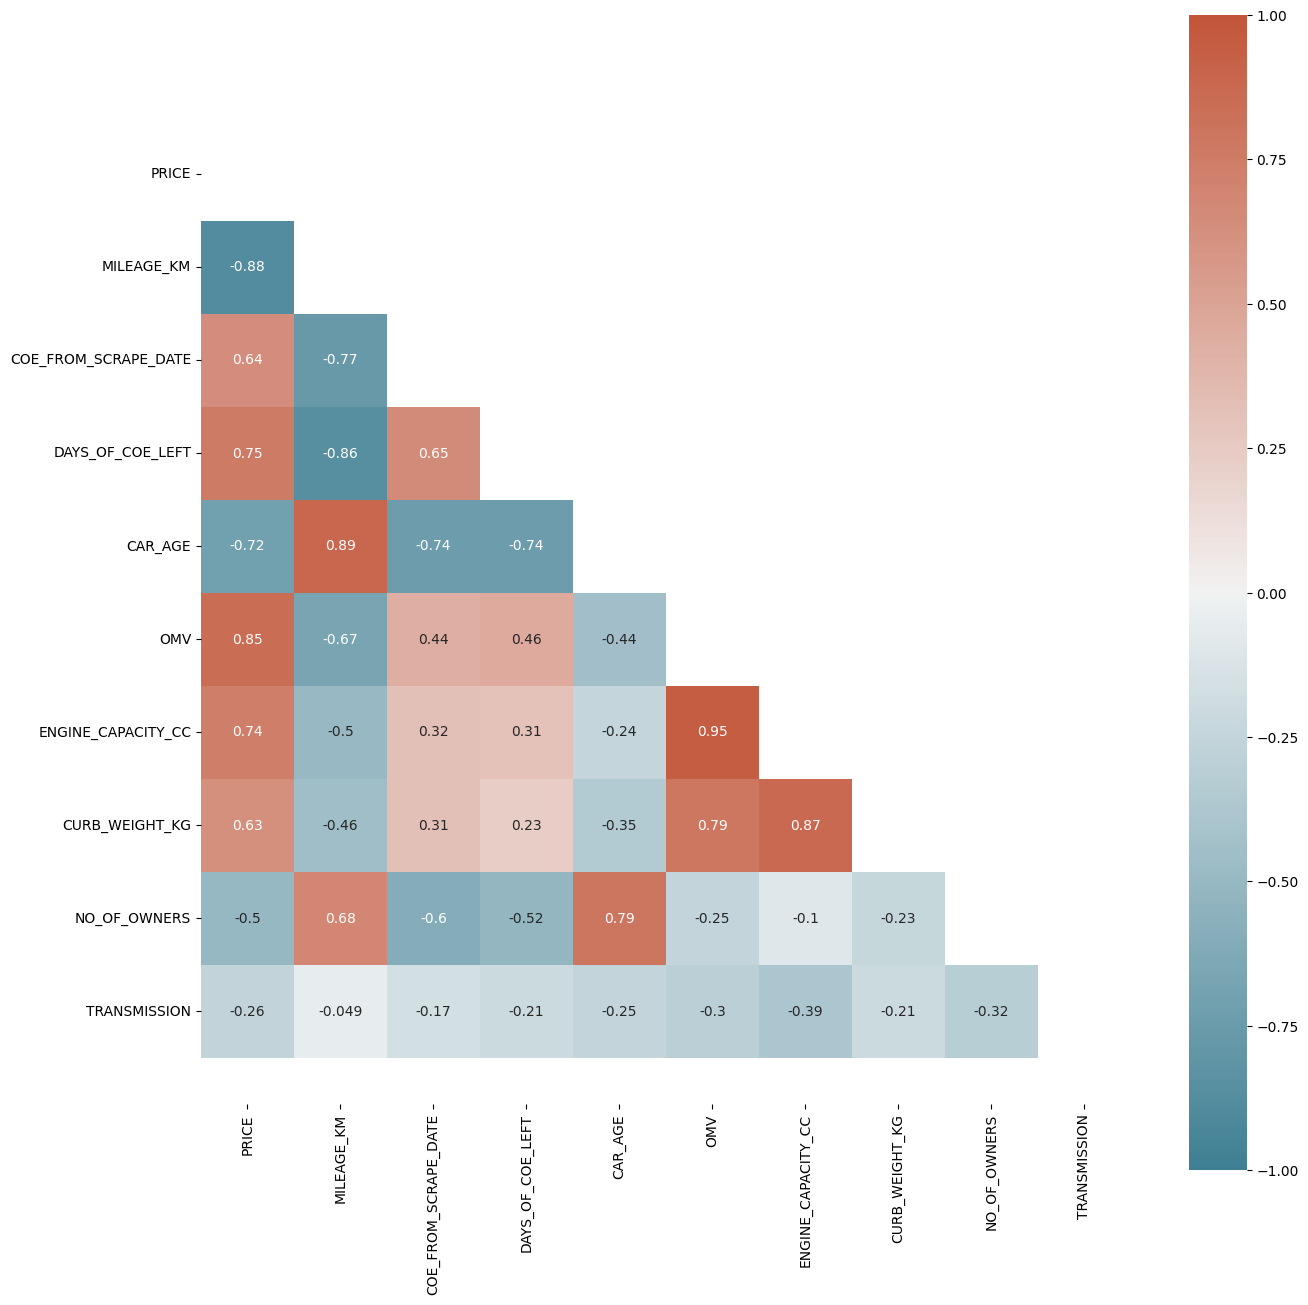

In [33]:
# Re-visualizing the correlation matrix

# Creating the data
data = df_price_no_brands.corr()

plot_corr_matrix_heatmap(data)

In [34]:
# Correlations of the independent variables (features) to dependent variable (target, price)
df_price_no_brands.corr()['PRICE'].sort_values(ascending=False)

PRICE                   1.000000
OMV                     0.630746
ENGINE_CAPACITY_CC      0.560515
DAYS_OF_COE_LEFT        0.478349
CURB_WEIGHT_KG          0.408985
COE_FROM_SCRAPE_DATE    0.344683
NO_OF_OWNERS           -0.013533
TRANSMISSION           -0.068941
CAR_AGE                -0.214191
MILEAGE_KM             -0.446287
Name: PRICE, dtype: float64

#### Section 3.1.3.1: Pairplot after Feature Selection

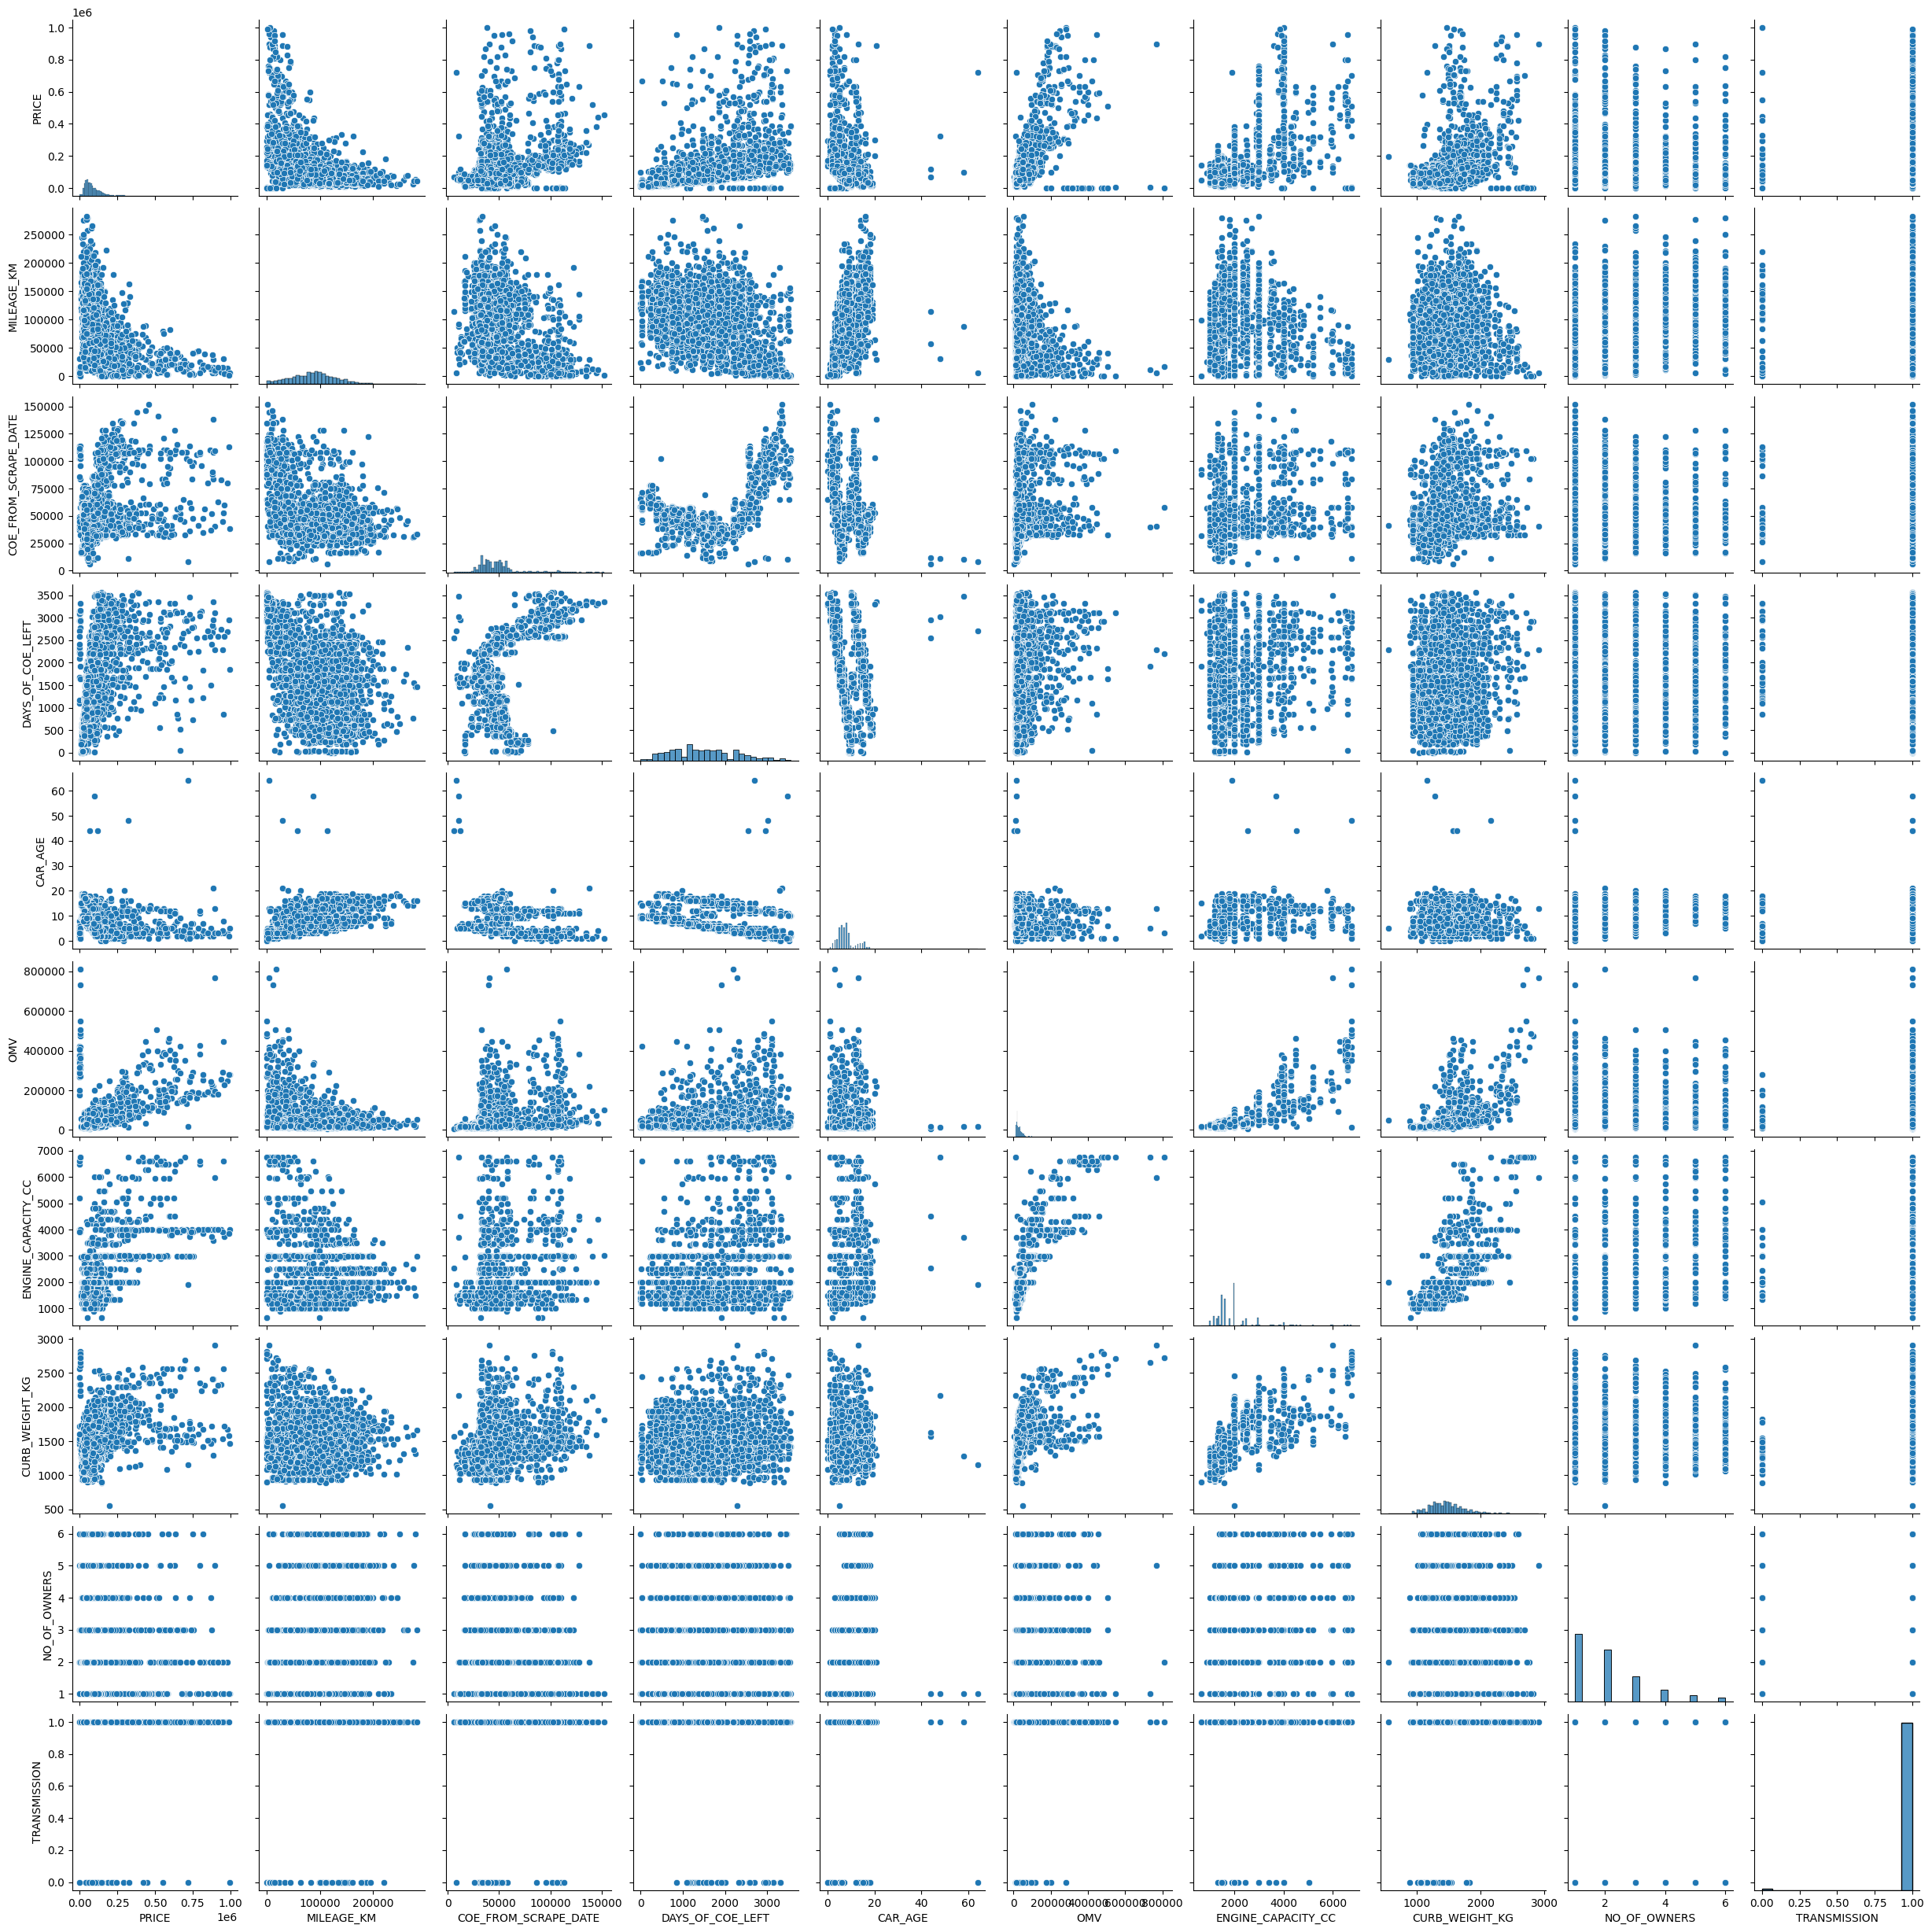

In [35]:
# Performing a pairplot to visualize the data trends of the variables

# We can see that price and mileage hold a negative linear relationship
# COE from the scrape date doesn't seem to have a very clear relatonship here
# Days of COE seems to have a slight linear r/s
# Car age doesn't seem to have a very distinct relationship here. But generally, the younger the car, the higher the price
# OMV has a clear increasing linear rs with price with price
# Engine capacity seems to also have a increasing linear r/s  with price, with a few outliers in the center
# Perhaps it's because a lot of the higher-priced cars (higher brands) are produced in that engine capacity range?
# Curb weight seems to have a linear r/s too.

sns.pairplot(df_price_no_brands);

In [36]:
df_price_no_brands.columns

Index(['PRICE', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

In [37]:
import sklearn.tree
import graphviz

model = sklearn.tree.DecisionTreeRegressor(max_depth=3)
# I've limited max_depth mostly for visualisation purposes

# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands[ ['MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
X = sm.add_constant(X)
Y = df_price_no_brands['PRICE'].astype(float)

# Assuming you have already loaded and preprocessed your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sklearn.tree.DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)

# Visualize the decision tree
dot_data = sklearn.tree.export_graphviz(model, out_file=None, 
                                       feature_names=X.columns,
                                       filled=True, rounded=True,
                                       special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")

ModuleNotFoundError: No module named 'graphviz'

### Section 3.2: Preliminary Model fitting to check R^2 Value and P>|t| values of Price and the leftover Independent Variables

In [41]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands[ ['MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
X = sm.add_constant(X)
Y = df_price_no_brands['PRICE'].astype(float)



In [ ]:
X.head()

In [ ]:
Y.head()

In [ ]:
# model / fit / summarize
print(linear_regression_analysis(X, Y))

In [ ]:
print(random_forest_analysis(X, Y))

### Section 3.2.1: Optimizing R^2 Value

#### Section 3.2.1.1: Checking Distributions & Pairplots of all Variables

##### Pairplot of Price vs Independent Variables (without any transformation)

In [ ]:
# Performing a pairplot to visualize the data trends of the variables

# We can see that price and mileage hold a negative linear relationship
# COE from the scrape date doesn't seem to have a very clear relatonship here
# Days of COE seems to have a slight linear r/s
# Car age doesn't seem to have a very distinct relationship here. But generally, the younger the car, the higher the price
# OMV has a clear increasing linear rs with price with price
# Engine capacity seems to also have a increasing linear r/s  with price, with a few outliers in the center
# Perhaps it's because a lot of the higher-priced cars (higher brands) are produced in that engine capacity range?
# Curb weight seems to have a linear r/s too.

sns.pairplot(df_price_no_brands);

##### Histograph of all Variables (Columns) in DataFrame

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(df_price_no_brands.columns):
    df_price_no_brands[col].hist(ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

From the above graphs, it would make sense to apply log transform on the following variables to make them
* more normally distributed
* Mileage
* Engine Cap
* Price
* OMV

## Distribution of Price

In [ ]:
sns.boxplot(df_price_no_brands['PRICE'])  # 

In [ ]:
sns.displot(df_price_no_brands['PRICE'])  # Your dependent variable 'must' be normally distributed

We see that price is right-skewed. Therefore, we can try applying a log onto price, then visualize the data again.

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(df_price_no_brands['PRICE'],ax=ax)
plt.xlabel('PRICE',size=10)
plt.savefig("price_no_log.png",transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(np.log(df_price_no_brands['PRICE']),ax=ax)
plt.xlabel("PRICE_LOG",size=10)
plt.savefig("price_log.png",transparent=True)

### Section 3.2.1: Logging Mileage ONLY

In [52]:
# Creating a copy of the dataframe to work log on
df_price_no_brands_only_mileage_logged = df_price_no_brands.copy()

In [ ]:
# Log Mileage
df_price_no_brands_only_mileage_logged["MILEAGE_LOG"] = df_price_no_brands_only_mileage_logged['MILEAGE_KM'].apply(np.log)
df_price_no_brands_only_mileage_logged

In [54]:
# Rearranging columns

df_price_no_brands_only_mileage_logged = \
df_price_no_brands_only_mileage_logged[['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [ ]:
df_price_no_brands_only_mileage_logged.columns

In [ ]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands_only_mileage_logged[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_price_no_brands_only_mileage_logged['PRICE'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

In [ ]:
print(random_forest_analysis(X, Y))

In [ ]:
# Visualizing Pairplots of Price vs Other Features and Only Mileage logged

sns.pairplot(df_price_no_brands_only_mileage_logged);

### Section 3.2.2: Normal Price with Logged Mileage and Squared Engine CC

In [59]:
# Creating a copy of the dataframe to work log on
df_price_no_brands_mileage_logged_squared_engine_cap = df_price_no_brands_only_mileage_logged.copy()

In [60]:
# Square Engine CC
df_price_no_brands_mileage_logged_squared_engine_cap["ENGINE_SQUARED"] = \
df_price_no_brands_mileage_logged_squared_engine_cap['ENGINE_CAPACITY_CC'].apply(lambda x: x**2)

In [ ]:
df_price_no_brands_mileage_logged_squared_engine_cap.columns

In [62]:
# Rearrange columns
df_price_no_brands_mileage_logged_squared_engine_cap = \
df_price_no_brands_mileage_logged_squared_engine_cap[['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [ ]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands_mileage_logged_squared_engine_cap[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_price_no_brands_only_mileage_logged['PRICE'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

In [ ]:
print(random_forest_analysis(X, Y))

In [ ]:
# Visualizing Pairplots of the distributions

sns.pairplot(df_price_no_brands_mileage_logged_squared_engine_cap);

In [ ]:
# Viewing Corr Matrix of Price vs Independent Variables (only logged mileage and squared engine CC)

data = df_price_no_brands_mileage_logged_squared_engine_cap.corr()

plot_corr_matrix_heatmap(data)

### Section 3.2.3: Logged Price with Logged Mileage and Squared Engine CC

In [67]:
df_logged_price_no_brands_mileage_logged_squared_engine_cap = df_price_no_brands_mileage_logged_squared_engine_cap.copy()

In [68]:
# Logging Price
df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE_LOG'] =\
df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE'].apply(np.log)

In [69]:
# Rearrange columns
df_logged_price_no_brands_mileage_logged_squared_engine_cap = \
df_logged_price_no_brands_mileage_logged_squared_engine_cap[['PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [ ]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_logged_price_no_brands_mileage_logged_squared_engine_cap[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE_LOG'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

In [ ]:
print(random_forest_analysis(X, Y))

### Section 3.2.3: Logged Price with Logged Mileage only (no engine squared)

In [72]:
df_logged_price_no_brands_only_mileage_logged = df_price_no_brands_only_mileage_logged.copy()

In [ ]:
sns.pairplot(df_logged_price_no_brands_only_mileage_logged);
plt.savefig("log_price_and_mileage.png")

In [74]:
# Logging Price
df_logged_price_no_brands_only_mileage_logged['PRICE'] = df_logged_price_no_brands_only_mileage_logged['PRICE'].apply(np.log)

# Renaming column
df_logged_price_no_brands_only_mileage_logged.rename(columns={'PRICE':'PRICE_LOG'},inplace=True)

In [ ]:
df_logged_price_no_brands_only_mileage_logged.columns

In [ ]:
df_logged_price_no_brands_only_mileage_logged.head()

In [ ]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_logged_price_no_brands_only_mileage_logged[['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_logged_price_no_brands_only_mileage_logged['PRICE_LOG'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

In [ ]:
print(random_forest_analysis(X, Y))